In [1]:
# Set up a cluster using dask
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()

cluster.scale(15)
cluster

In [2]:
#Make a client so you can see the progress of tasks (click the link that appears below)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.c62dfc83e49341689f3704fc2da142b7/status,


In [3]:
import intake
import pandas as pd
import pprint
import fsspec

import numpy as np
import xarray as xr
import xgcm
import xesmf as xe
import s3fs

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from fastjmd95 import jmd95numba

In [4]:
col = intake.open_esm_datastore(
    "https://raw.githubusercontent.com/NCAR/cesm-lens-aws/main/intake-catalogs/aws-cesm1-le.json")
col_subset = col.search(experiment="20C",variable=["TEMP", "SALT","UVEL","VVEL","WVEL","SHF","VNT","WTT","PD"])
#col_subset = col.search(experiment="20C",variable=["TEMP"])
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/tmp/ipykernel_885/1594392936.py:5: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})


In [5]:
ds = dsets['ocn.20C.monthly']
theta = ds.TEMP
salt = ds.SALT
uvel = ds.UVEL
vvel = ds.VVEL
wvel = ds.WVEL
vnt = ds.VNT
wtt = ds.WTT
pot_dens = ds.PD
shf = ds.SHF

url = "s3://ncar-cesm-lens/ocn/static/grid.zarr"
fs = s3fs.S3FileSystem(anon=True)
grid_ds = xr.open_zarr(s3fs.S3Map(url, s3=fs))

In [6]:
th0 = theta.roll(nlon=60).sel(nlon=slice(0,125))
slt0 = salt.roll(nlon=60).sel(nlon=slice(0,125))
uvel0 = uvel.roll(nlon=60).sel(nlon=slice(0,125))
vel0 = vvel.roll(nlon=60).sel(nlon=slice(0,125))
wvel0 = wvel.roll(nlon=60).sel(nlon=slice(0,125))
#vnt0 = vnt.roll(nlon=60)
#wtt0 = wtt.roll(nlon=60)
shf0 = shf.roll(nlon=60).sel(nlon=slice(0,125))
pd0 = pot_dens.roll(nlon=60).sel(nlon=slice(0,125))
grid0 = grid_ds.roll(nlon=60,roll_coords=True).sel(nlon=slice(0,125))



uvel0=uvel0.rename({'nlon':'vlon','nlat':'vlat'})
vel0=vel0.rename({'nlon':'vlon','nlat':'vlat'})

In [7]:
latit = slice(120,370)

In [ ]:
#Create a region mask for the Atlantic
atl_mask = grid0.REGION_MASK
atl_mask = atl_mask.where((atl_mask==6) | (atl_mask==8) | (atl_mask==9)| (atl_mask==11))
atl_mask = atl_mask.where(np.isnan(atl_mask),1)
#atl_mask = atl_mask.where(atl_mask.nlon>5)
#atl_mask = atl_mask.where(atl_mask.nlon<113)
atl_mask = atl_mask.where((atl_mask.nlon<108) | (atl_mask.nlat>331))
maskS = atl_mask.rename({'nlat':'vlat'}).sel(vlat=latit)

In [21]:
lons = atl_mask.TLONG[300,:].values
lons[lons>180] = lons[lons>180]-360


latupper= 357
lons2 = atl_mask.TLONG[latupper,:].values
lons2[lons2>180] = lons2[lons2>180]-360

lons_concat = np.concatenate((lons[3:125],lons2[125:3:-1]))
lats_concat = np.concatenate((atl_mask.TLAT[300,3:125],atl_mask.TLAT[latupper,125:3:-1]))

lons_40 = atl_mask.TLONG[286,23:90].values
lons_40[lons_40>180] = lons_40[lons_40>180]-360
lats_40 = atl_mask.TLAT[286,23:90].values


lons_26 = atl_mask.TLONG[270,23:85].values
lons_26[lons_26>180] = lons_26[lons_26>180]-360
lats_26 = atl_mask.TLAT[270,23:85].values

lons_m5 = atl_mask.TLONG[163,60:125].values
lons_m5[lons_m5>180] = lons_m5[lons_m5>180]-360
lats_m5 = atl_mask.TLAT[163,60:125].values

In [22]:
#create grid object

#first merge v and w 

ds = vel0.to_dataset().merge(wvel0)
ds = ds.merge(th0)
ds = ds.merge(uvel0)
ds = ds.merge(pd0)
ds = ds.merge(grid0.DXU.rename({'nlon':'vlon','nlat':'vlat'}).rename('gridS'))
ds = ds.merge(grid0.DYU.rename({'nlon':'vlon','nlat':'vlat'}).rename('gridW'))
z_outer = np.concatenate((ds.z_w_top.values,np.asarray(550000).reshape((-1,))))
ds = ds.assign_coords(z_w_outer=z_outer)

from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

grid = Grid(ds, coords={'X':{'center': 'nlon','right': 'vlon'},'Y':{'center': 'nlat','right': 'vlat'},'Z': {'center': 'z_t','outer': 'z_w_outer'}},periodic=False)

#calculate dz
dz = grid0.dz#grid.diff(ds.z_w_outer,axis='Z',boundary='extend')

In [23]:
mid=slice(1,37)
timeslice = slice('1940-01-01','2016-02-01')
df = pd.DataFrame({'date1':pd.date_range('1941-01-01','1941-12-01',freq='MS'),
                   'date2':pd.date_range('1941-02-01','1942-01-01', freq='MS')})
df['diff'] = df['date2']-df['date1']
dt = df['diff'].dt.total_seconds().to_numpy()
ds_dt = xr.DataArray(np.repeat(dt,66),coords={'time':ds.TEMP.sel(time=timeslice).time.values},dims=['time'])

In [24]:

pick_id = 1
vs = grid.interp(ds.VVEL*ds.gridS,'X',boundary='fill').sel(vlat=latit).sel(member_id=pick_id)
deltaxS = grid.interp(ds.gridS,'X',boundary='fill').sel(vlat=latit)
pdS = grid.interp(ds.PD*1000,'Y',boundary='fill').sel(vlat=latit).sel(member_id=pick_id)

vel_mean = (vs*dz*maskS).sum(['nlon','z_t'])/(xr.ones_like(vs).where(np.isfinite(vs))*dz*maskS).sum(['nlon','z_t'])

vel_notf = vs - vel_mean

pd_jmd = jmd95numba.rho(slt0, th0, 0)
pd_jmd1 = jmd95numba.rho(slt0, th0, 1000)

#rho_axis=np.concatenate((np.arange(20,27,0.1),np.arange(27,28.1,0.01)))
rho_axis=np.concatenate((np.arange(20,27.6,0.1),np.arange(27.7,28.1,0.01)))
#rho_axis1=np.arange(25,33,0.1)

#transform into density coords
MOC_jmd1 = grid.transform(vel_notf*dz*maskS/100**3, target = rho_axis, target_data=(pdS.rename('PD')-1000), 
                     method='conservative', mask_edges=True, suffix='_transformed', axis = 'Z')

#transport in member 1
transport_1 = MOC_jmd1

transport_43N = transport_1.sel(time=timeslice)#.rolling(time=3).mean().dropna("time",how='all')

PDloc=80
transport_above = transport_43N.isel(PD=slice(0,PDloc)).sum('PD')

/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:1109: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/grid.py:303: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.<function raw_interp_function at 0x7fcc36d475b0>` instead of `Axis.<function raw_interp_function at 0x7fcc36d475b0>`
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xgcm/t

In [25]:
long_34N = xr.open_dataset('/home/jovyan/amoc_heat_transport/long_34N.nc')
long_26N = xr.open_dataset('/home/jovyan/amoc_heat_transport/long_26N.nc')
long_5S = xr.open_dataset('/home/jovyan/amoc_heat_transport/long_5S.nc')

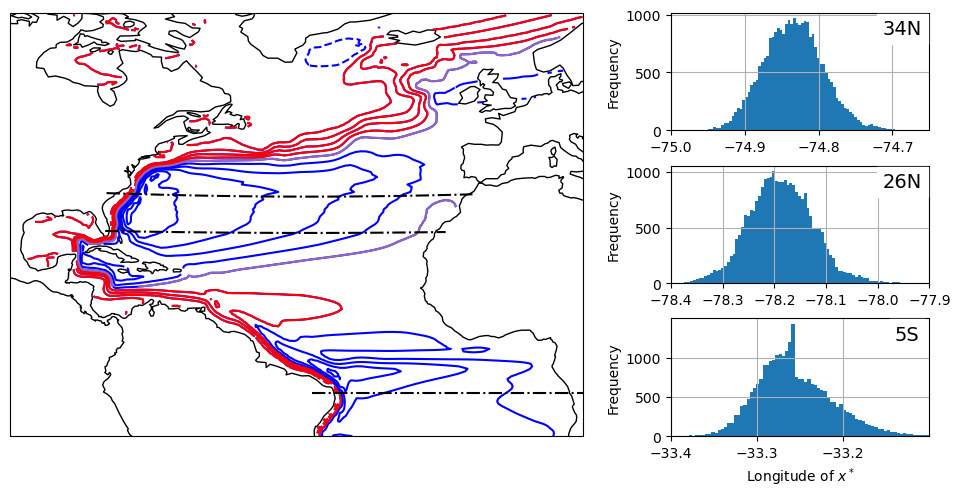

In [26]:
import cartopy.crs as ccrs
import cartopy

fig = plt.figure(figsize=(12,5.5))
gs = fig.add_gridspec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=ccrs.PlateCarree())

ds_out = xr.Dataset({'lat': (['lat'], np.arange(-15, 70, 0.5)),
                     'lon': (['lon'], np.arange(-100, 15, 0.1)),
                    }
                   )

transport_sf = ((transport_above.mean('time')).cumsum('nlon')*maskS).rename({'TLONG':'lon','TLAT':'lat'}).drop_vars(['ULONG','ULAT']).load()
regridder = xe.Regridder(transport_sf, ds_out, 'bilinear')
dr_out = regridder(transport_sf)



ax.coastlines()
#dr_out.plot(ax=ax, transform=ccrs.PlateCarree())
cs=ax.contour(dr_out.lon,dr_out.lat,dr_out.values/10**6,levels=np.arange(-30,50,5),colors='b',
                          transform = ccrs.PlateCarree())

ax.contour(dr_out.lon,dr_out.lat,dr_out.values/10**6,levels=np.arange(0,20,5),colors='r',
                          transform = ccrs.PlateCarree())

ax.contour(dr_out.lon,dr_out.isel(lat=slice(60,180)).lat,dr_out.isel(lat=slice(60,180)).values/10**6,levels=[-20,20],colors='tab:purple',
                          transform = ccrs.PlateCarree())

ax.plot(lons_26,lats_26,'k',transform = ccrs.PlateCarree(),linestyle='-.')
ax.plot(lons_m5,lats_m5,'k',transform = ccrs.PlateCarree(),linestyle='-.')
                                  
ax.plot(lons_40,lats_40,'k',transform = ccrs.PlateCarree(),linestyle='-.')   

ax.set_extent([-100, 15, -15, 70], crs=ccrs.PlateCarree())

#plt.colorbar(cs)

#(transport_above.isel(member_id=0).mean('time')*deltaxS).cumsum('nlon').plot()

ax1 = fig.add_subplot(gs[0, 2])

plt.hist(np.ravel(long_34N.dropna(dim='time').lon_34N.values), bins='auto') 

plt.ylabel('Frequency')
plt.grid()
plt.xlim(-75,-74.65)
t = plt.text(-74.713, 830, '34N',fontsize=14)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax2 = fig.add_subplot(gs[1, 2])

plt.hist(np.ravel(long_26N.dropna(dim='time').lon_26N.values), bins='auto') 

plt.ylabel('Frequency')
plt.grid()
plt.xlim(-78.4,-77.9)
t = plt.text(-77.99, 860, '26N',fontsize=14)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax3 = fig.add_subplot(gs[2, 2])

plt.hist(np.ravel(long_5S.dropna(dim='time').lon_5S.values), bins='auto') 
plt.xlabel('Longitude of $x^*$')
plt.ylabel('Frequency')
plt.grid()
plt.xlim(-33.4,-33.1)
plt.xticks(np.arange(-33.4,-33.1,0.1))
t = plt.text(-33.14, 1230, '5S',fontsize=14)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))


fig = plt.gcf()
fig.subplots_adjust(hspace=0.3,wspace=0.3)

fig.savefig('pseudo_streamfunction.eps')

In [27]:
cluster.shutdown()

2023-06-29 19:36:46,924 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
